In [1]:
ir_id_hetionet = "Disease::DOID:99999"
ir_id_obl = "HP:0000855"

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

from scipy.spatial.distance import pdist, squareform

def calculate_distances(X, y, metric='euclidean'):
    dmat = squareform(pdist(X, metric=metric))

    dmat_pos = dmat[y][:, y]
    ds_pos = dmat_pos[np.triu_indices(dmat_pos.shape[0], k=1)]

    dmat_neg = dmat[~y][:, ~y]
    ds_neg = dmat_neg[np.triu_indices(dmat_neg.shape[0], k=1)]
    
    ds = dmat[np.triu_indices_from(dmat, k=1)]

    return ds, ds_pos, ds_neg

In [4]:
dataset = 'Hetionet'
prefix = 'RotatE'

embedding_dir = Path('./1_outputs/standard/')
embedding_files = sorted(list(embedding_dir.glob(f'{prefix}_*.npy')))

ref_df_path = Path('./1_outputs/standard/ref_df.csv')
ref_df = pd.read_csv(ref_df_path, index_col=0)
y = ref_df['y'].values

X = []
for ef in embedding_files:
    X.append(np.load(ef)[ref_df.index])
X = np.concatenate(X, axis=1)

In [50]:
tsne = TSNE()
X_tf = tsne.fit_transform(X)

[Text(0.5, 36.72222222222221, 't-SNE 1')]

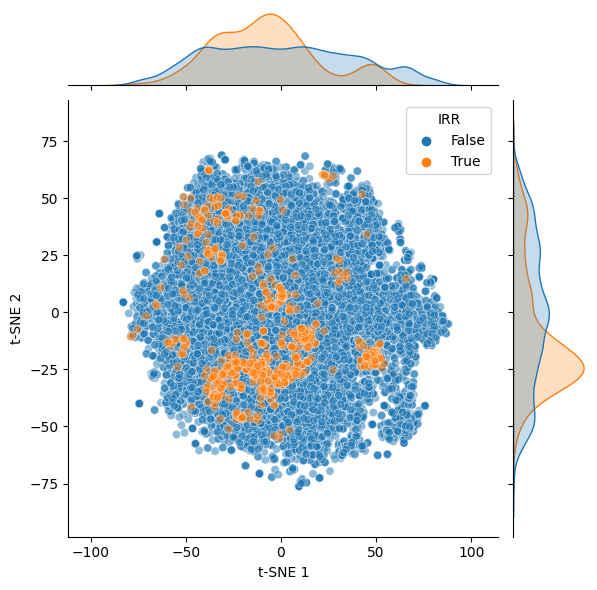

In [51]:
df = pd.DataFrame({'t-SNE 1': X_tf[:, 0], 't-SNE 2': X_tf[:, 1], 'IRR': y})
grid = sns.jointplot(df.sort_values('IRR'), x='t-SNE 1', y='t-SNE 2', hue='IRR', alpha=0.5, marginal_kws=dict(common_norm=False))

plot = grid.ax_joint
plot.set(ylabel='t-SNE 2')
plot.set(xlabel='t-SNE 1')

In [53]:
ds, ds_pos, ds_neg = calculate_distances(X, y)
ds_neg_samp = np.random.choice(ds_neg, 100000)

df = pd.DataFrame({
    'group': np.r_[np.repeat('IRR', ds_pos.shape[0]), np.repeat('Unknown', ds_neg_samp.shape[0])],
    'distance': np.r_[ds_pos, ds_neg_samp],
})
df['distance'] = (df['distance'] - ds.mean()) / ds.std()

<Axes: xlabel='group', ylabel='distance'>

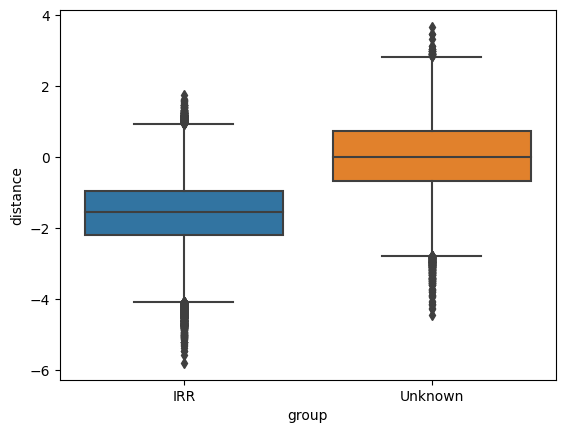

In [54]:
sns.boxplot(df, x='group', y='distance')

<Axes: xlabel='distance', ylabel='Density'>

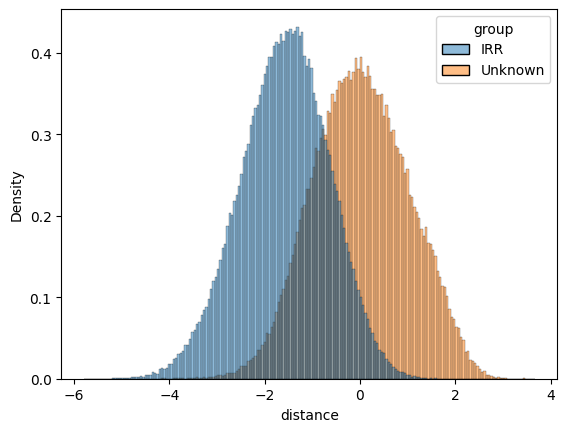

In [55]:
sns.histplot(df, hue='group', x='distance', common_norm=False, stat='density')

In [ ]:
from tqdm import tqdm

mean_ds = []
std_ds = []
mean_ds_pos = []
mean_ds_neg = []

y_shuffled = y.copy()
np.random.shuffle(y_shuffled)

for ef in tqdm(embedding_files):
    _ds, _ds_pos, _ds_neg = calculate_distances(np.load(ef)[ref_df.index], y_shuffled)
    mean_ds.append(_ds.mean())
    std_ds.append(_ds.std())
    mean_ds_pos.append(_ds_pos.mean())
    mean_ds_neg.append(_ds_neg.mean())

 10%|█         | 1/10 [01:13<11:05, 73.91s/it]

In [ ]:
mean_ds = np.array(mean_ds)
std_ds = np.array(std_ds)
mean_ds_pos = np.array(mean_ds_pos)
mean_ds_neg = np.array(mean_ds_neg)

In [ ]:
df2 = pd.DataFrame({
    'group': np.r_[np.repeat('IRR', mean_ds_pos.shape[0]), np.repeat('Unknown', mean_ds_neg.shape[0])],
    'distance': np.r_[(mean_ds_pos - mean_ds) / std_ds, (mean_ds_neg - mean_ds) / std_ds],
})

In [ ]:
from scipy.stats import ttest_rel

t_res = ttest_rel(df2.query('group == "IRR"')['distance'], df2.query('group == "Unknown"')['distance'])

plot = sns.boxplot(df2, x='group', y='distance')
plot.set_ylabel('Normalized Euclidean Distance')
plot.set_xlabel('')
plot.set_title(f"{dataset} - {prefix}\np value: {t_res.pvalue:.2E}")

In [60]:
embedding_path = Path('./1_outputs/standard/CompGCN_X_1.npy')
ref_df_path = Path('./1_outputs/standard/ref_df.csv')

In [61]:
X_all = np.load(embedding_path)

ref_df = pd.read_csv(ref_df_path, index_col=0)
X = X_all[ref_df.index]
y = ref_df['y'].values

In [62]:
tsne = TSNE()
X_tf = tsne.fit_transform(X)

[Text(0.5, 36.72222222222221, 't-SNE 1')]

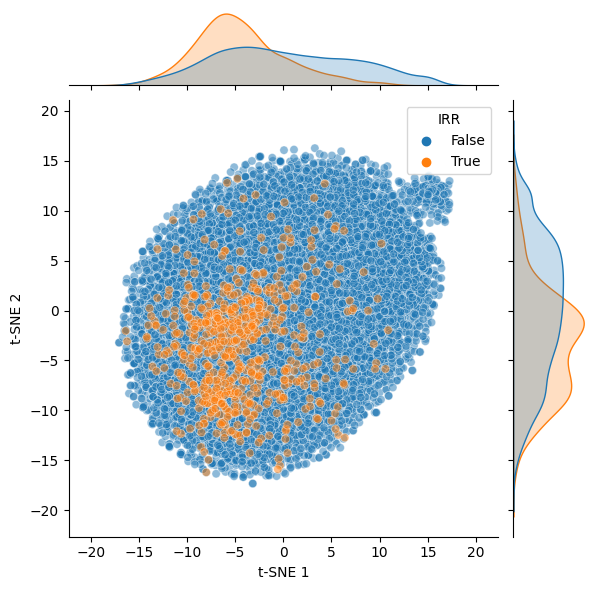

In [63]:
df = pd.DataFrame({'t-SNE 1': X_tf[:, 0], 't-SNE 2': X_tf[:, 1], 'IRR': y})
grid = sns.jointplot(df.sort_values('IRR'), x='t-SNE 1', y='t-SNE 2', hue='IRR', alpha=0.5, marginal_kws=dict(common_norm=False))

plot = grid.ax_joint
plot.set(ylabel='t-SNE 2')
plot.set(xlabel='t-SNE 1')